Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [X] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [X] Make at least 1 partial dependence plot to explain your model.
- [X] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction.
- [ ] If you log-transformed your regression target, then convert your PDP back to original units. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox.I Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')
### Select features, scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
import category_encoders as ce

import xgboost as xgb
from xgboost import XGBClassifier

from scipy.stats import randint, uniform

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

import eli5
from eli5.sklearn import PermutationImportance

### Wrangle function
def wrangle(df):
    """I heard you like docstrings"""
    import numpy as np
    
    ### Easy stuff
    # Copy the dataframe to itself so warnings can shsshshsh
    df = df.copy()
    
    df['latitude'] = df['latitude'].replace(-2e-08,0)
    df['date_recorded'] = pd.to_datetime(df['date_recorded'],infer_datetime_format=True)
    df['year_recorded'] = df['date_recorded'].dt.year
    df['month_recorded'] = df['date_recorded'].dt.month
    df['day_recorded'] = df['date_recorded'].dt.day
    
    # Drop dupes
    df = df.drop(columns=['id','date_recorded','quantity_group',
                          'scheme_management','quality_group',
                          'waterpoint_type_group','extraction_type_group'])

    # Ryan's Engineer feature: how many years from construction_year to date_recorded
    df['years'] = df['year_recorded'] - df['construction_year']
    df['years_MISSING'] = df['years'].isnull()

    # YEEHAW dataframe return
    return df

### Do this cool permutation importance thing
def permutationCreator(X_train, y_train):
    ## Transform manually cause pipelines don't work
    transformers = make_pipeline(
        ce.OrdinalEncoder(),
        SimpleImputer(strategy='mean')
    )
    X_train_t = transformers.fit_transform(X_train)
        
    ## Create model and fit
    # n_esties 550
    model = RandomForestClassifier(n_estimators=100,random_state=4,n_jobs=-1)
    model.fit(X_train_t, y_train)
    
    ## Fit permutation stuff
    permuter = PermutationImportance(
        model,
        scoring = 'accuracy',
        n_iter = 4,
        random_state = 4
    )
    permuter.fit(X_train_t,y_train)
    features = X_train.columns.tolist()
    return permuter, features

### Prune by feature importance
def featureImportance(train, permuter, min_imp):
    mask = permuter.feature_importances_ > min_imp
    features = train.columns[mask]
    X_train = train[features]
    
    return X_train, features

### Get that cool green/red graph
def permutationColor(permuter, features):
    x = eli5.show_weights(
        permuter, feature_names=features, top=None
    )
    return x

###########################################################
##### !!!!
### Random Forest w/ Ordinal Encoder
rf = make_pipeline(
    ce.OrdinalEncoder(),
    #ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    # n_estimators is # of trees in forest
    ## n_estimators=650
    RandomForestClassifier(n_estimators=250,random_state=4,n_jobs=-1)
)

### Cross-validation Pipeline
pipeline = make_pipeline(
    # All params are going to be in a separate dictionary below X_train
    ce.TargetEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=4)
)

### Make target
target = 'status_group'
# Assign variables
X_train = wrangle(train)
X_train = X_train.drop(target,axis=1)
y_train = train[target]

#features = X_train.columns.tolist()
#X_test = wrangle(test)
status_map = {'functional needs repair':1,'functional':2,'non functional':0}
y_train = y_train.map(status_map)

## Get permuter
permuter, features_old = permutationCreator(X_train, y_train)

### Get feature importances
X_train, features = featureImportance(X_train, permuter, .0005)

### Pretty permutation colours!
##permutationColor(permuter, features_old)
param_dist = {
    'targetencoder__min_samples_leaf': randint(1,100),
    'targetencoder__smoothing': uniform(1,100),
    'simpleimputer__strategy': ['mean','median'],
    'randomforestclassifier__n_estimators': randint(1,100,10),
    'randomforestclassifier__max_depth': [25, 50, 75, 100, None], 
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    # Randomly try 100 options sampling
    n_iter=20,
    cv=3,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

print(train.status_group.unique())
print(X_train.shape,y_train.shape)
print(X_train.columns)
search.fit(X_train,y_train)
pipeline = search.best_estimator_
X_test = wrangle(test)
X_test = X_test[features]
#y_test = X_test[target]
#status_map = {2:'functional',1:'functional needs repair',0:'non functional'}
#y_test['status_group'] = y_test['status_group'].map(status_map)
y_pred = pipeline.predict(X_test)

['functional' 'non functional' 'functional needs repair']
(59400, 33) (59400,)
Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quantity', 'source', 'source_type',
       'waterpoint_type', 'month_recorded', 'day_recorded', 'years'],
      dtype='object')
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   22.5s
/home/ygeun/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed:   47.4s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done  51 out of  60 | elapsed:   52.1s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:   58.7s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   58.9s finished


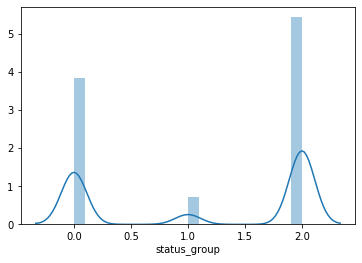

In [3]:
import seaborn as sns
sns.distplot(y_train);

In [7]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [28]:
import sys, getpass
a = getpass.getuser()
### example appending of folder
# A
sys.path.append('/home/{}/Code/Github-Repos/BFLibrary/'.format(a))
# B
sys.path.append('/Users/{}/Programs/BFLibrary/'.format(a))
#from BFLibrary import ACompass, BWarp, CToolbox 
import AMap as am
import BCook as bc
import CTools as ct

In [29]:
from pdpbox.pdp import pdp_plot, pdp_isolate
from pdpbox import pdp

target = 'status_group'
features, _, _ = bc.allPantryFeatures(X_train)
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X_train)

model = RandomForestClassifier(n_estimators=20, random_state=4, n_jobs=-1)
model.fit(X_encoded,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                       oob_score=False, random_state=4, verbose=0,
                       warm_start=False)

(<Figure size 1080x1080 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f399ffa1550>,
  'pdp_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x7f399ff9a978>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7f39bc873978>]})

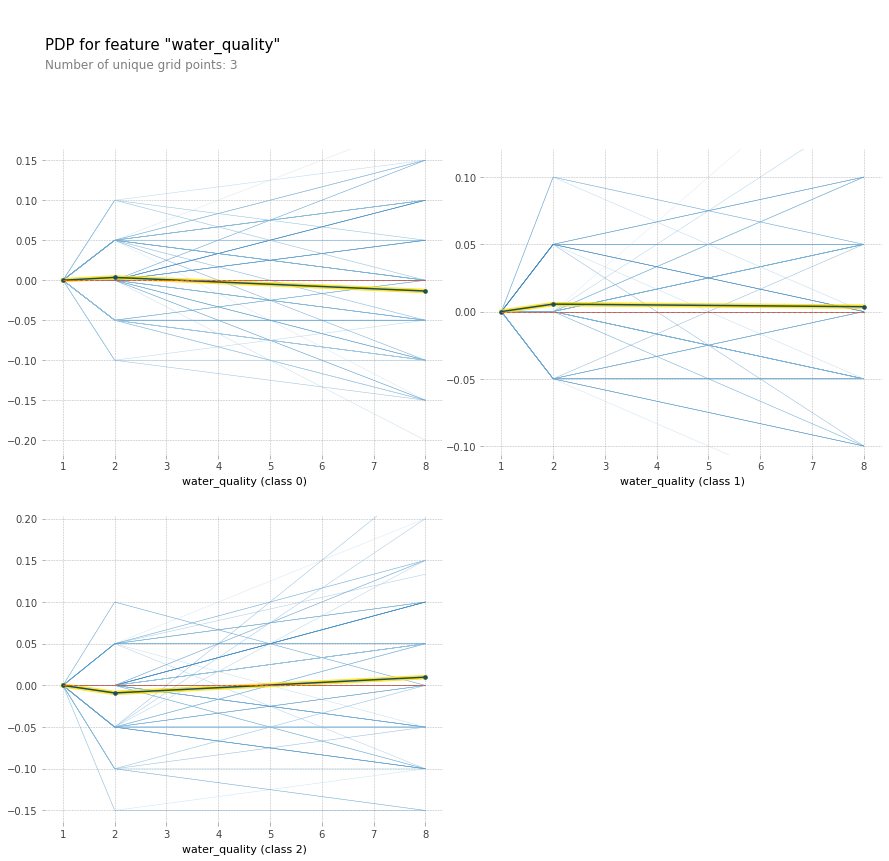

In [33]:
feature= 'water_quality'

pdp_dist = pdp.pdp_isolate(
    model=model,
    dataset=X_encoded,
    model_features=features,
    feature=feature,
    num_grid_points=10
)
pdp_plot(pdp_dist,feature_name=feature,
         plot_lines=True, frac_to_plot=100)

In [32]:
train.water_quality.unique()

array(['soft', 'salty', 'milky', 'unknown', 'fluoride', 'coloured',
       'salty abandoned', 'fluoride abandoned'], dtype=object)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


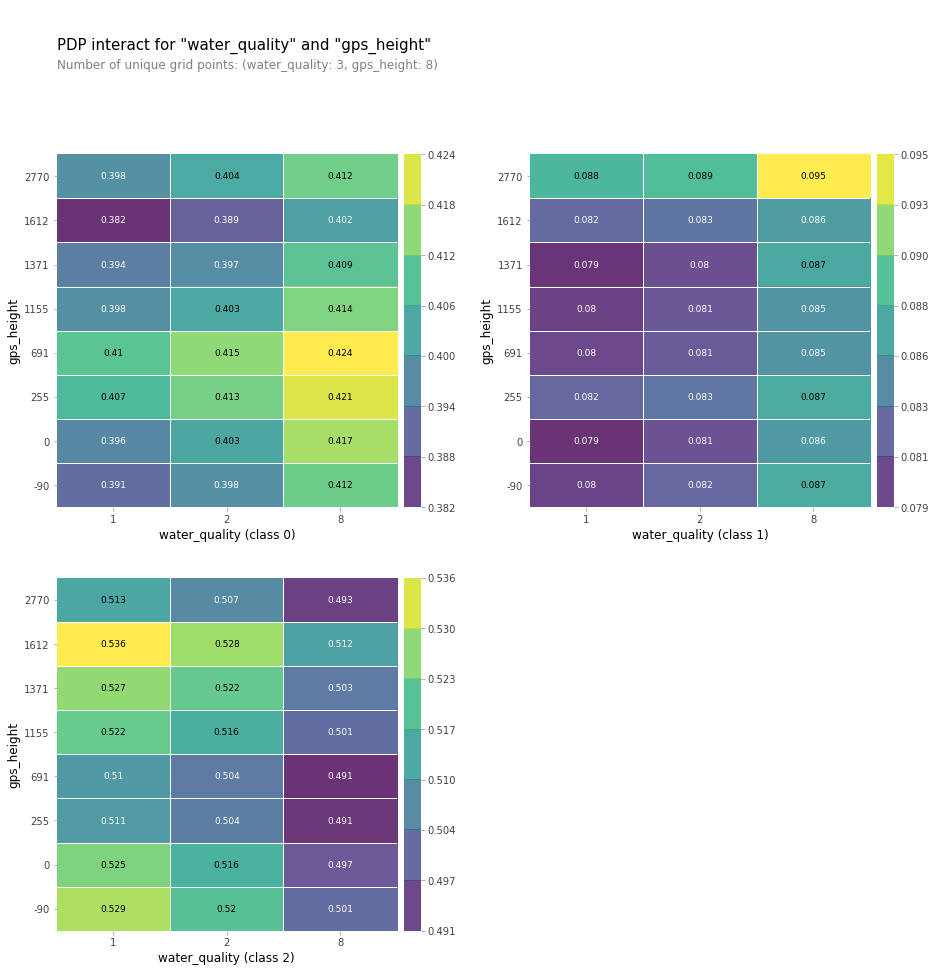

In [34]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['water_quality','gps_height']

interaction = pdp_interact(
    model=model,
    dataset=X_encoded,
    model_features=X_encoded.columns,
    features=features
)
pdp_interact_plot(interaction, plot_type='grid',feature_names=features);

In [38]:
X_encoded.water_quality.unique()

array([1, 2, 3, 4, 5, 6, 7, 8])